In [6]:
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

## Dataset Loading
##### Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

In [ ]:
import zipfile
import shutil

zip_path = "PlantVillage.zip"
extract_to = "temp_folder"
current_dir = os.getcwd()

print("Extracting...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_to)

source_folder = os.path.join(extract_to, "PlantVillage")
destination_folder = os.path.join(current_dir, "PlantVillage")


if os.path.exists(source_folder):
    shutil.move(source_folder, destination_folder)
    print(f"PlantVillage is now in: {current_dir}")
    
    shutil.rmtree(extract_to)
    

Extracting...
Success! PlantVillage is now in: d:\projects\potato disease\tmp


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './PlantVillage',
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset) #shows no. of batches formed

68

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 0 0 1 2 1 0 1 1 1 0 0 0 2 0 1 0 0 0 2 0 1 1 0 1 0 1 1]


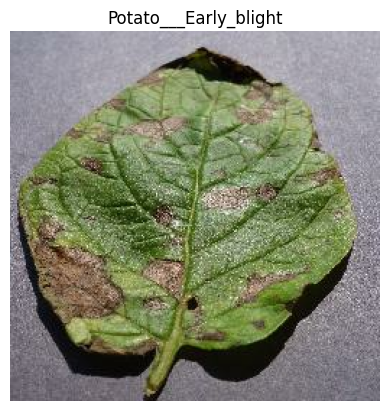

In [ ]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(f'{class_names[label_batch[0]]}')
    plt.axis('off')

## Train test split
80% train, 10% validation, 10% test

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds), len(val_ds), len(test_ds),

(54, 6, 8)

## Training Optimization

In [ ]:
# Improves training speed
#       cache -> saves time by not having to read the file agian during each epoch
#       prefetch -> saves time by making the CPU to run parellely with GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Data Preprocessing and Augmentation Layers

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentaion = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

## Model Building & Training

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentaion,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.4893 - loss: 0.8952 - val_accuracy: 0.6979 - val_loss: 0.6642
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7265 - loss: 0.6444 - val_accuracy: 0.8021 - val_loss: 0.5640
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8297 - loss: 0.4116 - val_accuracy: 0.5625 - val_loss: 1.0505
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.7020 - loss: 0.8042 - val_accuracy: 0.7552 - val_loss: 0.5001
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8001 - loss: 0.4640 - val_accuracy: 0.7656 - val_loss: 0.5318
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8517 - loss: 0.3755 - val_accuracy: 0.7865 - val_loss: 0.5139
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.8239 - loss: 0.4130 - val_accuracy: 0.8646 - val_loss: 0.3784
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8448 - loss: 0.3522 - val_accuracy: 0.9167 -

In [ ]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9491 - loss: 0.1229


[0.1158628836274147, 0.9453125]

## Training Visualization

In [ ]:
print(history.params)

{'verbose': 1, 'epochs': 50, 'steps': 54}


In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:
len(history.history['accuracy'])

50

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

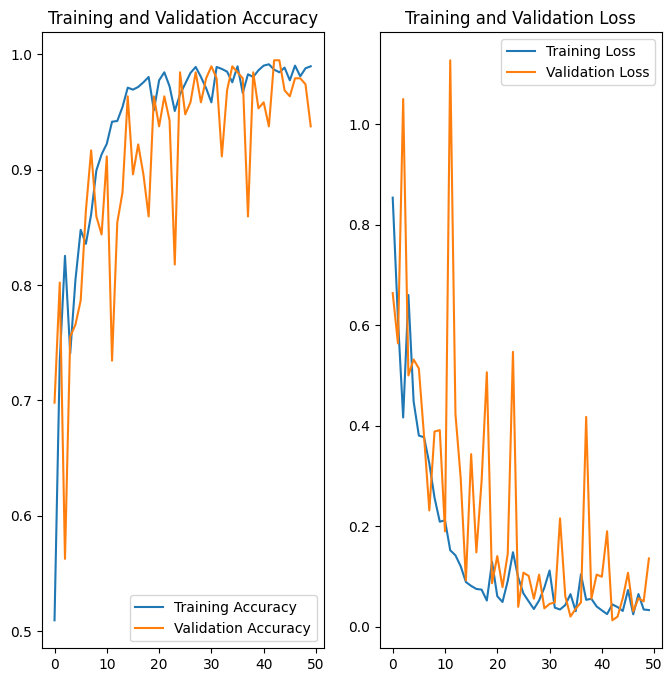

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Making the Predictions

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = 100 * (np.max(predictions[0]))
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


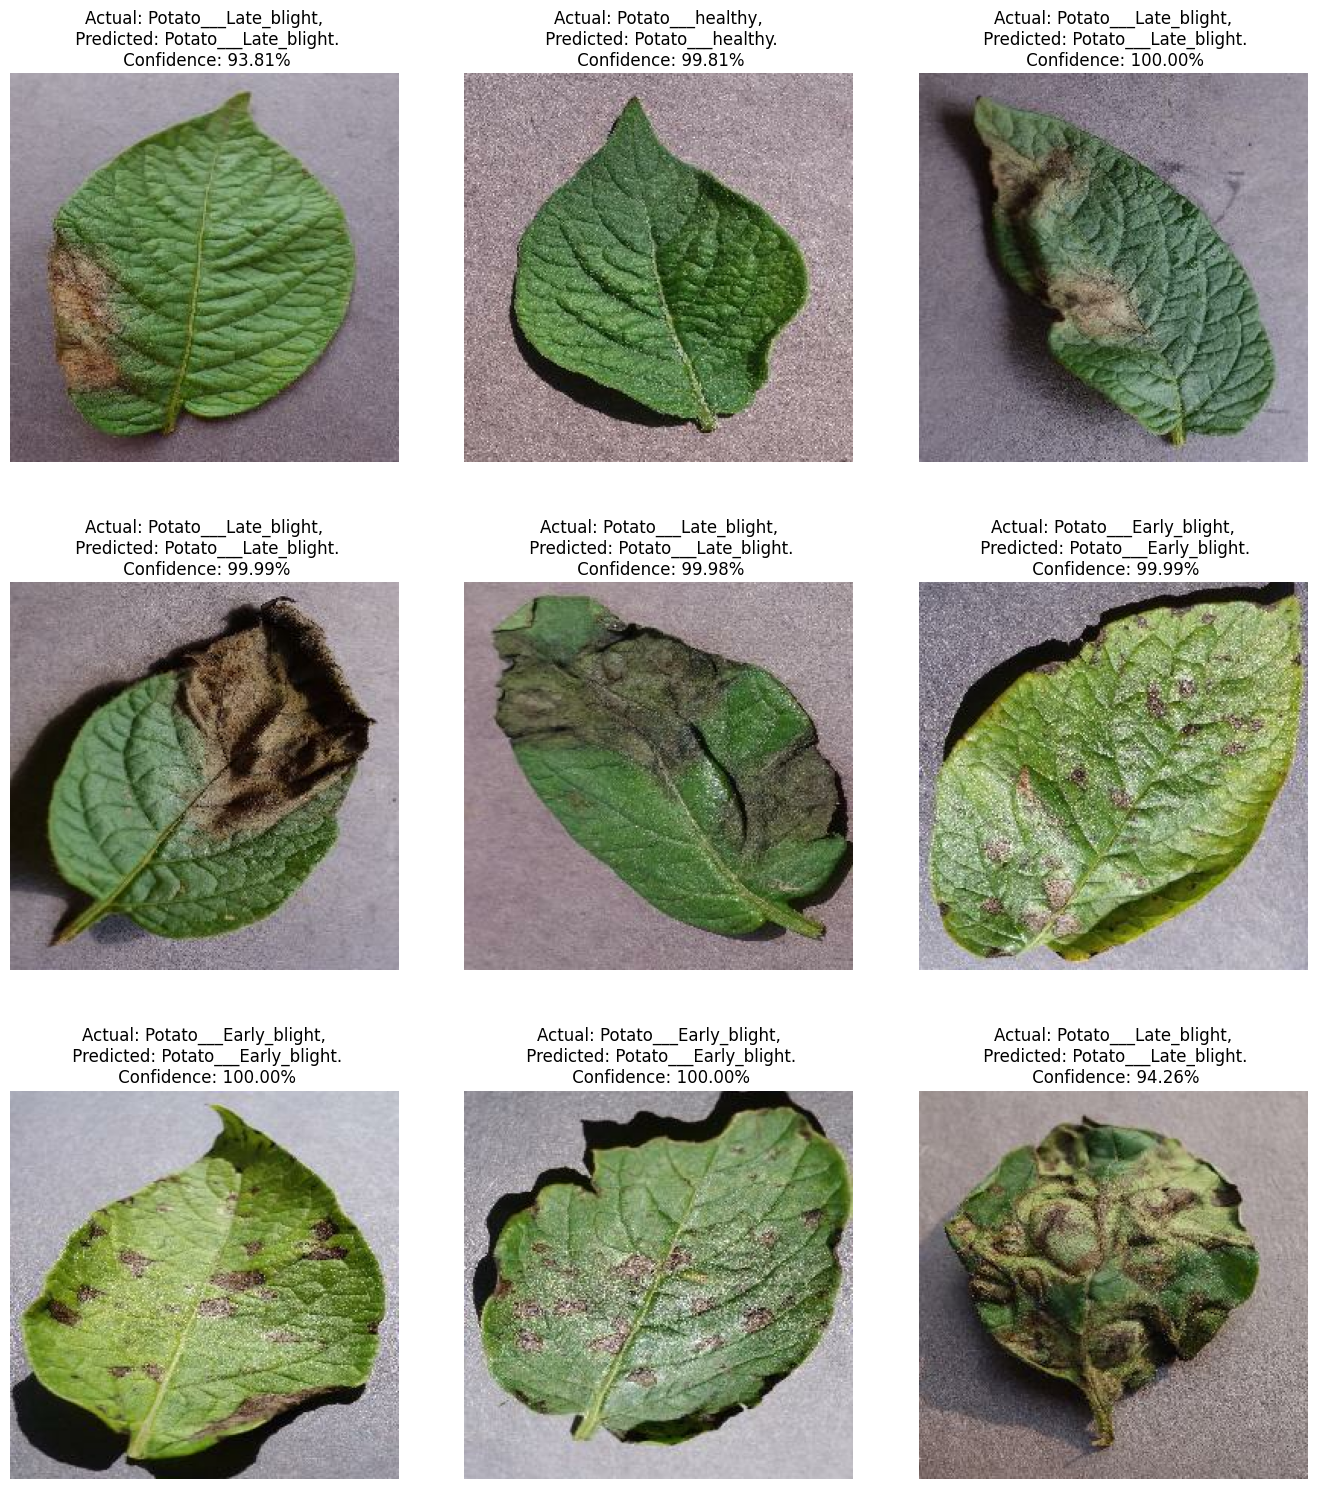

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence:.2f}%")

        plt.axis("off")
        plt.tight_layout(h_pad=4.0)

## Saving our Model

In [ ]:
folder_path = "models"

# Create the directory if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

model.save(os.path.join(folder_path, "potatoes.keras"))